# Let's replace the nn model with a parameterised quantum circuit

In [24]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

# from data import harmonic_oscillator_solution
# from lossfn import mse, boundary_loss, physics_loss, physics_loss_imp
# from model import Hybrid_QN
# from utils import draw_circuit

import pennylane as qml

from IPython.display import clear_output

In [25]:
torch.manual_seed(123)
n_qubits = 5
n_layers = 10
n_qubit_input = 1
n_qubit_output = 1


# DATA USED

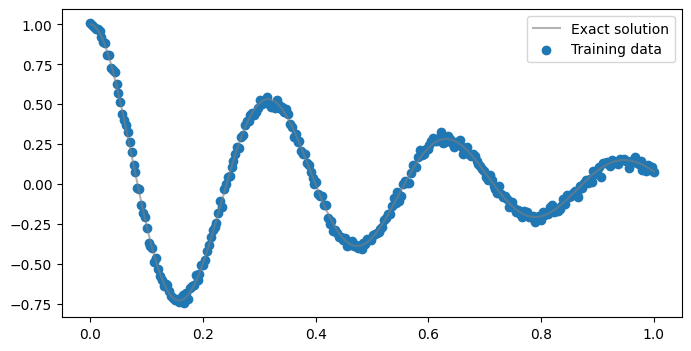

In [26]:
def harmonic_oscillator_solution(d, w0, t):

    ''' Analytical solution to a under-damped harmonic oscillator, I am just going to use the solution given above
    - d - delta, the damping ratio,
    - w0 - undamped angular frequency,
    - t - time,
    '''

    assert d < w0 # check for undamped case
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    x = exp*2*A*cos
    
    return x

# Full dataset
data = pd.read_csv('./time-oscillation.csv', dtype=np.float32)

d, w0 = 2, 20
t_true = torch.linspace(0,1,500).view(-1,1)
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'].values).view(-1,1)
obs_data = torch.tensor(data['observation'].values).view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true, color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

For simplicity, we only get 16% of data for training, as below:

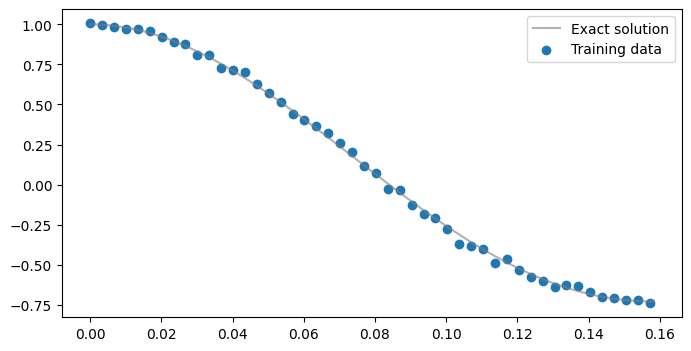

In [27]:
percentage = 16

d, w0 = 2, 20
t_true = torch.linspace(0,1,500).view(-1,1)[:int(np.ceil(percentage/100*500))]
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'].values)[:int(np.ceil(percentage/100*len(data)))].view(-1,1)
obs_data = torch.tensor(data['observation'].values)[:int(np.ceil(percentage/100*len(data)))].view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true, color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

# Model and Loss functions

Please don't mind this lengthy code block

In [28]:
# Hybrid model and restriction on weights
class Hybrid_QN(nn.Module):
    '''
    Quantum layer -> Classical 1 layer
    '''

    def __init__(self, N_OUTPUT: int, Q_NODE):
        super().__init__()
        # self.clayer_1= nn.Linear(N_INPUT, N_QUBITS)
        self.qlayer_1 = Q_NODE
        self.clayer_2 = nn.Linear(N_OUTPUT, N_OUTPUT)

    def forward(self, x):
        # x = self.clayer_1(x)
        x = self.qlayer_1(x)
        x = self.clayer_2(x)
        return x
    
# Apply this after every optimisation step
class WeightClipper(object):
    def __call__(self, module, param_range=[0, np.pi]):
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = w.clamp(param_range[0], param_range[1])
            module.weight.data = w

def boundary_loss(prediction, t_boundary) -> torch.Tensor:
    ''' The **boundary loss**, tries to ensure that the solution learned by the PINN matches the initial conditions of the system.
    
    Returns the loss function for 2 initial conditions
    '''

    # minimising first condition that x(t=0) = 1 (see data notebook)
    loss1 = (torch.squeeze(prediction) - 1)**2

    dxdt = torch.autograd.grad(prediction, t_boundary, torch.ones_like(prediction), create_graph=True)[0]
    loss2 = (torch.squeeze(dxdt) - 0)**2

    return loss1, loss2

def physics_loss(prediction, t_physics, mu, k) -> torch.Tensor:
    ''' The **physics loss**, tries to ensure that the PINN solution obeys the underlying differential equation (see data notebook).
    
    Return the loss function for the harmonic oscillator DE 
    '''


    dxdt = torch.autograd.grad(prediction, t_physics, torch.ones_like(prediction), create_graph=True)[0]

    d2xdt2 = torch.autograd.grad(dxdt, t_physics, torch.ones_like(dxdt), create_graph=True)[0]
    loss = torch.mean((d2xdt2 + mu*dxdt + k*prediction)**2)

    return loss

def draw_circuit(circuit, fontsize=20, style='pennylane', expansion_strategy=None, scale=None, title=None, decimals=2):
    def _draw_circuit(*args, **kwargs):
        nonlocal circuit, fontsize, style, expansion_strategy, scale, title
        qml.drawer.use_style(style)
        if expansion_strategy is None:
            expansion_strategy = circuit.expansion_strategy
        fig, ax = qml.draw_mpl(circuit, decimals=decimals, expansion_strategy=expansion_strategy)(*args, **kwargs)
        if scale is not None:
            dpi = fig.get_dpi()
            fig.set_dpi(dpi*scale)
        if title is not None:
            fig.suptitle(title, fontsize=fontsize)
        plt.show()
    return _draw_circuit

In [29]:
dev = qml.device("default.qubit.torch", wires=n_qubits)

def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubit_output)]

qnode = qml.QNode(qnode, dev, interface='torch', expansion_strategy='gradient')

weight_shapes = {"weights": qml.StronglyEntanglingLayers.shape(n_layers, n_qubits)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [30]:
list(qlayer.parameters())

[Parameter containing:
 tensor([[[1.8605, 3.2457, 1.5813],
          [4.3263, 0.4648, 5.4445],
          [0.8582, 0.6439, 1.1565],
          [4.5644, 1.9808, 4.3172],
          [0.4752, 1.2355, 1.9881]],
 
         [[2.5242, 0.7450, 5.1987],
          [2.4007, 4.1500, 5.3631],
          [3.7269, 4.0007, 6.1740],
          [1.7247, 4.1367, 1.7438],
          [5.3867, 5.6506, 0.2451]],
 
         [[5.8234, 4.6417, 4.5106],
          [4.4349, 5.7532, 2.7268],
          [0.4848, 2.2401, 0.9290],
          [3.3493, 2.5550, 1.4565],
          [2.8560, 6.1179, 2.8938]],
 
         [[3.2413, 2.6516, 3.6355],
          [5.9408, 5.0627, 4.2567],
          [3.8243, 3.8824, 4.3553],
          [2.7356, 0.2218, 1.1988],
          [5.8232, 3.3294, 0.5967]],
 
         [[3.6371, 5.7374, 0.1728],
          [1.0265, 1.8904, 3.2677],
          [2.4089, 2.7964, 0.0789],
          [4.6127, 5.8991, 5.0619],
          [0.9169, 0.6091, 4.4461]],
 
         [[3.2121, 4.4294, 0.0718],
          [2.9543, 5.3572,

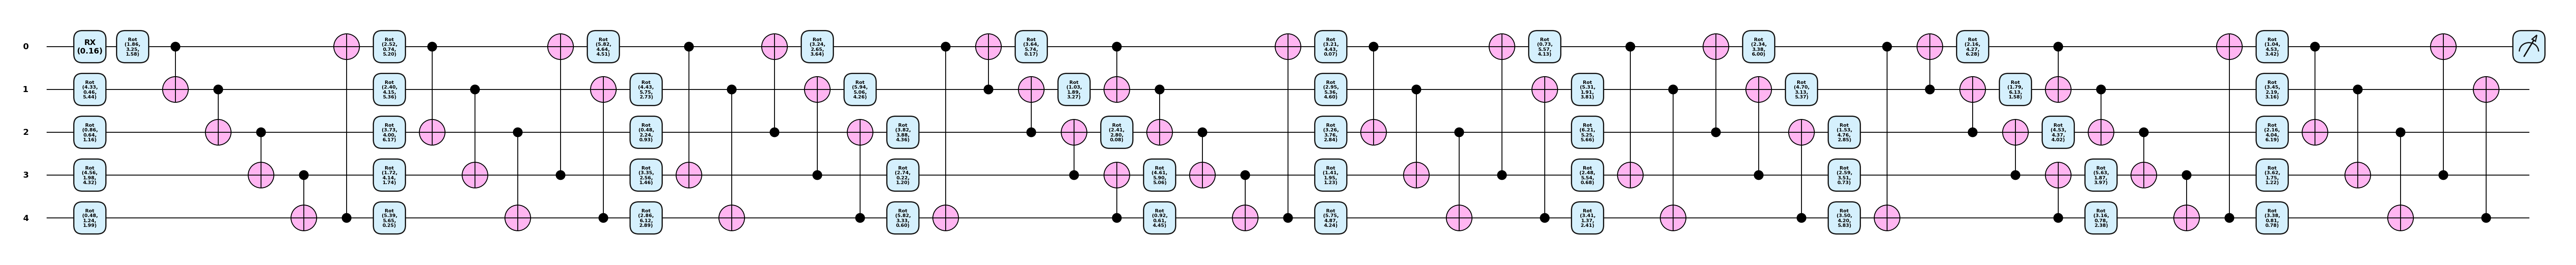

In [31]:
draw_circuit(qnode, expansion_strategy='device')(t_data[-1], list(qlayer.parameters())[-1])

In [32]:
# qmodel = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
qmodel = Hybrid_QN(n_qubit_output, qlayer)
# qmodel = Pure_QN(qlayer)

In [33]:
# For initial condition loss
t_initial = torch.tensor(0.).view(-1,1).requires_grad_(True)

t_data = t_data.requires_grad_(True)

d = 2
w0 = 20
mu = 2*d
k = w0**2

# mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True)) # mu is missing, let's train it!
# all_mus = []

learning_rate=0.05
optimiser = torch.optim.Adam(list(qmodel.parameters()), lr=learning_rate)

# weighting the loss functions, see block below
lambda1, lambda2, lambda3, lambda4 = 1e5, 1e5, 1, 1e5

clipper = WeightClipper()
mseloss = nn.MSELoss()

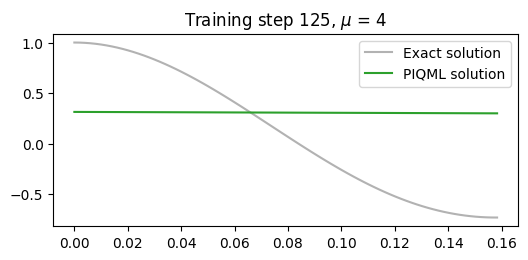

In [34]:
for i in range(200001):
    optimiser.zero_grad()

    # Loss function for initial conditions
    prediction = qmodel(t_initial)
    loss1, loss2 = boundary_loss(prediction, t_boundary=t_initial)

    # Physics loss with DE
    prediction = qmodel(t_data)
    loss3 = physics_loss(prediction, t_physics=t_data, mu=mu, k=k)

    # Combine loss
    loss4 = mseloss(prediction, obs_data)
    
    loss = lambda1*loss1 + lambda2*loss2 + lambda3*loss3 + lambda4*loss4

    # loss:torch.Tensor = lambda2*loss3 + mse(prediction, obs_data)

    loss.backward()

    optimiser.step()

    qmodel.apply(clipper)

    # all_mus.append(mu.item())

    if i % 1 == 0: 
        clear_output(wait=True)
        prediction = qmodel(t_true).detach()
        plt.figure(figsize=(6,2.5))
        plt.plot(t_true[:,0], obs_true[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_true[:,0], prediction[:,0], label="PIQML solution", color="tab:green")
        plt.title(f"Training step {i}, $\mu$ = {mu}")
        plt.legend()
        plt.show()
        print(f'''
        Report on loss fns: 
        - Boundary Loss 1: {loss1}
        - Boundary Loss 2: {loss2}
        - Physical Loss: {loss3}
        - MSE: {loss4}
        ''')
        # print(list(qmodel.parameters())) # Uncomment this to see parameters updating


In [9]:
## MSE
np.mean((harmonic_oscillator_solution(d=2, w0=20, t=t_true) - qmodel(t_true)).detach().numpy())**2

0.06659489096945492

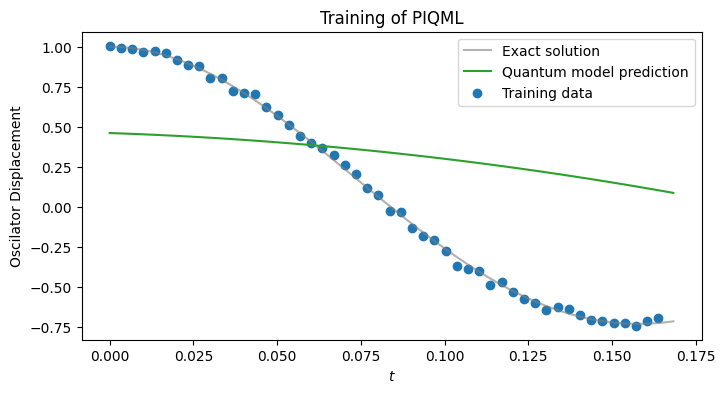

In [10]:
def plot_result(x,y,x_data,y_data,yh, title=None):

    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(x,y, color="tab:grey", alpha=0.6, label="Exact solution")
    plt.plot(x,yh, color="tab:green", label="Quantum model prediction")
    plt.scatter(x_data, y_data, label='Training data')
    plt.ylabel('Oscilator Displacement')
    plt.xlabel('$t$')
    l = plt.legend(loc='best')

plot_result(
    t_true.detach(),
    obs_true.detach(),
    t_data.detach(),
    obs_data.detach(),
    prediction,
    title='Training of PIQML'
    )

mu = Parameter containing:
tensor([16.5384], requires_grad=True)


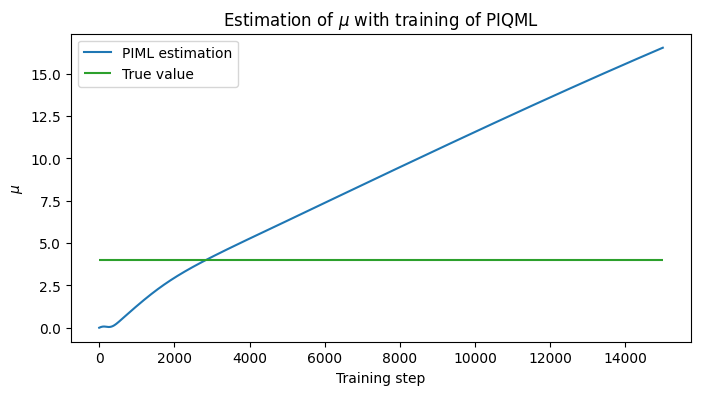

In [11]:
# print(f'mu = {mu}')

# plt.figure(figsize=(8,4))
# plt.title("Estimation of $\mu$ with training of PIQML")
# plt.plot(all_mus, label="PIML estimation")
# plt.hlines(2*d, 0, len(all_mus), label="True value", color="tab:green")
# plt.legend(loc='best')
# plt.xlabel("Training step")
# plt.ylabel("$\mu$")
# plt.show()